In [1]:
import numpy as np
from scipy.linalg import lu_factor, lu_solve
from scipy.sparse import bmat, csc_matrix
from scipy.sparse.linalg import splu, spsolve
from scipy.linalg import ldl
import scipy.sparse as sp
import scipy.linalg as la
from scipy.linalg import null_space
import matplotlib.pyplot as plt
import time
import seaborn as sns


In [2]:
np.random.seed(2025)

### Question 3

In [8]:
# main function
def EqualityQPSolver(H, g, A, b, solver='lu_dense'):
    if solver == 'lu_dense':
        return EqualityQPSolverLUdense(H, g, A, b)
    elif solver == 'lu_sparse':
        return EqualityQPSolverLUsparse(H, g, A, b)
    elif solver == 'ldl_dense':
        return EqualityQPSolverLDLdense(H, g, A, b)
    elif solver == 'ldl_sparse':
        return EqualityQPSolverLDLsparse(H, g, A, b)
    elif solver == 'range_space':
        return EqualityQPSolverRangeSpace(H, g, A, b)
    elif solver == 'null_space':
        return EqualityQPSolverNullSpace(H, g, A, b)
    
# LU dense solver
def EqualityQPSolverLUdense(H, g, A, b):
    H = H.toarray() if sp.issparse(H) else H
    A = A.toarray() if sp.issparse(A) else A

    n = H.shape[0]
    m = A.shape[1]

    KKT = np.block([
        [H, A],
        [A.T, np.zeros((m, m))]
    ])
    rhs = -np.concatenate([g, b])

    lu, piv = lu_factor(KKT)
    sol = lu_solve((lu, piv), rhs)
    x = sol[:n]
    lam = sol[n:]
    return x, lam

# LU sparse solver
def EqualityQPSolverLUsparse(H, g, A, b):
    H = csc_matrix(H)
    A = csc_matrix(A)

    n = H.shape[0]
    m = A.shape[1]

    KKT = bmat([
        [H, A],
        [A.T, None]
    ], format='csc')

    rhs = -np.concatenate([g, b])
    lu = splu(KKT)
    sol = lu.solve(rhs)
    x = sol[:n]
    lam = sol[n:]
    return x, lam

# LDL dense solver
def EqualityQPSolverLDLdense(H, g, A, b):
    H = H.toarray() if sp.issparse(H) else H
    A = A.toarray() if sp.issparse(A) else A
    
    n = H.shape[0]
    m = A.shape[1]

    KKT = np.block([
        [H, A],
        [A.T, np.zeros((m, m))]
    ])
    rhs = -np.concatenate([g, b])

    L, D, perm = ldl(KKT)
    y = np.linalg.solve(L, rhs[perm])
    z = np.linalg.solve(D, y)
    sol = np.linalg.solve(L.T, z)
    sol = sol[np.argsort(perm)]
    x = sol[:n]
    lam = sol[n:]
    return x, lam

# LDL sparse solver
# Note that CHOLMOD only works for symmetric positive definite matries so this function is defined by simulating LDL-like behavior using a sparse direct solver on the KKT system:
def EqualityQPSolverLDLsparse(H, g, A, b):
    H = sp.csc_matrix(H)
    A = sp.csc_matrix(A)
    n = H.shape[0]
    m = A.shape[1]

    # build indefinite KKT system
    KKT = sp.bmat([
        [H, A],
        [A.T, None]
    ], format='csc')

    rhs = -np.concatenate([g, b])

    sol = spsolve(KKT, rhs)
    x = sol[:n]
    lam = sol[n:]
    return x, lam

# Range space solver
def EqualityQPSolverRangeSpace(H, g, A, b):
    H = H.toarray() if sp.issparse(H) else H
    A = A.toarray() if sp.issparse(A) else A

    # solve A^T x = b => x = A (A^T H^-1 A)^-1 (A^T H^-1 g - b)
    Hinv = np.linalg.inv(H)
    W = A.T @ Hinv @ A
    rhs = A.T @ Hinv @ g + b
    lam = np.linalg.solve(W, rhs)
    x = -np.linalg.solve(H, g + A @ lam)
    return x, lam

# Null space solver
def EqualityQPSolverNullSpace(H, g, A, b):
    H = H.toarray() if sp.issparse(H) else H
    A = A.toarray() if sp.issparse(A) else A

    Z = null_space(A.T)

    if Z.shape[1] == 0:
        # no null space so must solve directly
        x = np.linalg.solve(H, -g)
        rhs = -(H @ x + g)
        lam, *_ = np.linalg.lstsq(A, rhs, rcond=None)
        return x, lam

    # use least squares for y instead of inverse becayse A^T.A may not be square
    ATA = A.T @ A
    if ATA.shape[0] != ATA.shape[1]:
        raise ValueError(f"A.T @ A is not square: {ATA.shape}")
    y, *_ = np.linalg.lstsq(ATA, b, rcond=None)
    x_p = A @ y

    HZ = Z.T @ H @ Z
    gZ = Z.T @ (H @ x_p + g)

    # solve reduced system (HZ should be square)
    if HZ.shape[0] != HZ.shape[1]:
        raise ValueError("HZ is not square — cannot solve")
    z = -np.linalg.solve(HZ, gZ)

    x = x_p + Z @ z
    rhs = -(H @ x + g)
    lam, *_ = np.linalg.lstsq(A, rhs, rcond=None)

    return x, lam

### Question 4

In [9]:
def generate_test_problem(n, beta=0.5, alpha=1e-2):

    m = int(round(beta * n))
    
    # generate sparse matrix A in R^nxm with 15% nonzero entries
    density = 0.15
    A = sp.random(n, m, density=density, data_rvs=np.random.randn, format='csc')

    # generate sparse matrix M in R^nxm with 15% nonzero entries
    M = sp.random(n, n, density=density, data_rvs=np.random.randn, format='csc')

    # compute H = M M^T + alpha*I (symmetric positive definite)
    H = (M @ M.T).tocsc()
    H += alpha * sp.identity(n, format='csc')

    # true solution vectors
    x_star = np.random.randn(n)
    lambda_star = np.random.randn(m)

    # compute g and b
    g = np.ravel(-H @ x_star - A @ lambda_star)
    b = np.ravel(A.T @ x_star)

    return H, g, A, b, x_star, lambda_star

### Question 5

Testing n = 50 ...
Testing n = 100 ...
Testing n = 200 ...
Testing n = 500 ...
Testing n = 1000 ...
Testing n = 2000 ...


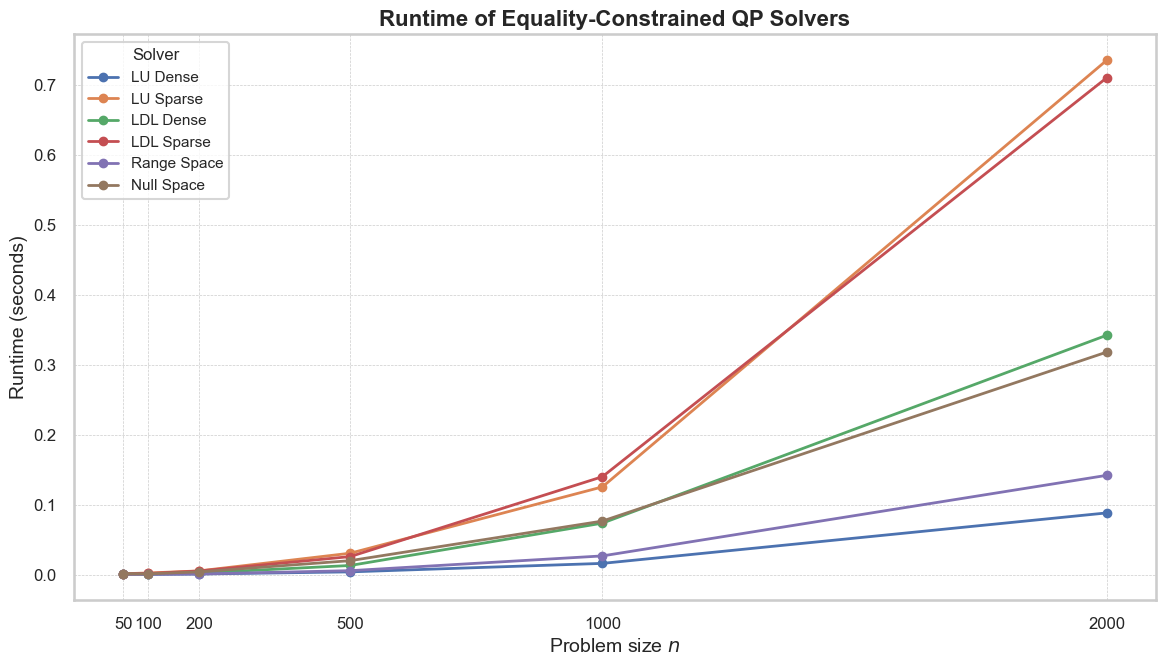

In [10]:
# use EqualityQPSolver, time each solver, plot run time vs n (problem size)
def qp_solvers(solvers, problem_sizes, beta=0.3):
    timings = {solver: [] for solver in solvers}

    for n in problem_sizes:
        print(f"Testing n = {n} ...")
        H, g, A, b, x_true, lambda_true = generate_test_problem(n, beta=beta)

        for solver in solvers:
            try:
                start = time.time()
                x, lam = EqualityQPSolver(H, g, A, b, solver=solver)
                elapsed = time.time() - start
            except Exception as e:
                print(f"  Solver {solver} failed at n={n}: {e}")
                elapsed = np.nan
            timings[solver].append(elapsed)

    return timings

# solver list to make the plot
solvers = ['lu_dense', 'lu_sparse', 'ldl_dense', "ldl_sparse", 'range_space', 'null_space']

# n values for plot
n = [50, 100, 200, 500, 1000, 2000]

# run and save to results
results = qp_solvers(solvers, n, beta=0.3)

solver_labels = {
    'lu_dense': 'LU Dense',
    'lu_sparse': 'LU Sparse',
    'ldl_dense': 'LDL Dense',
    'ldl_sparse': 'LDL Sparse',
    'range_space': 'Range Space',
    'null_space': 'Null Space'
}

sns.set(style="whitegrid", context="talk")

# plot results
plt.figure(figsize=(12, 7))
for solver in solvers:
    plt.plot(n, results[solver], marker='o', linewidth=2, markersize=6, label=solver_labels[solver])

plt.xlabel("Problem size $n$", fontsize=14)
plt.ylabel("Runtime (seconds)", fontsize=14)
plt.title("Runtime of Equality-Constrained QP Solvers", fontsize=16, weight='bold')

plt.xticks(n, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Solver", fontsize=11, title_fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

### Question 6

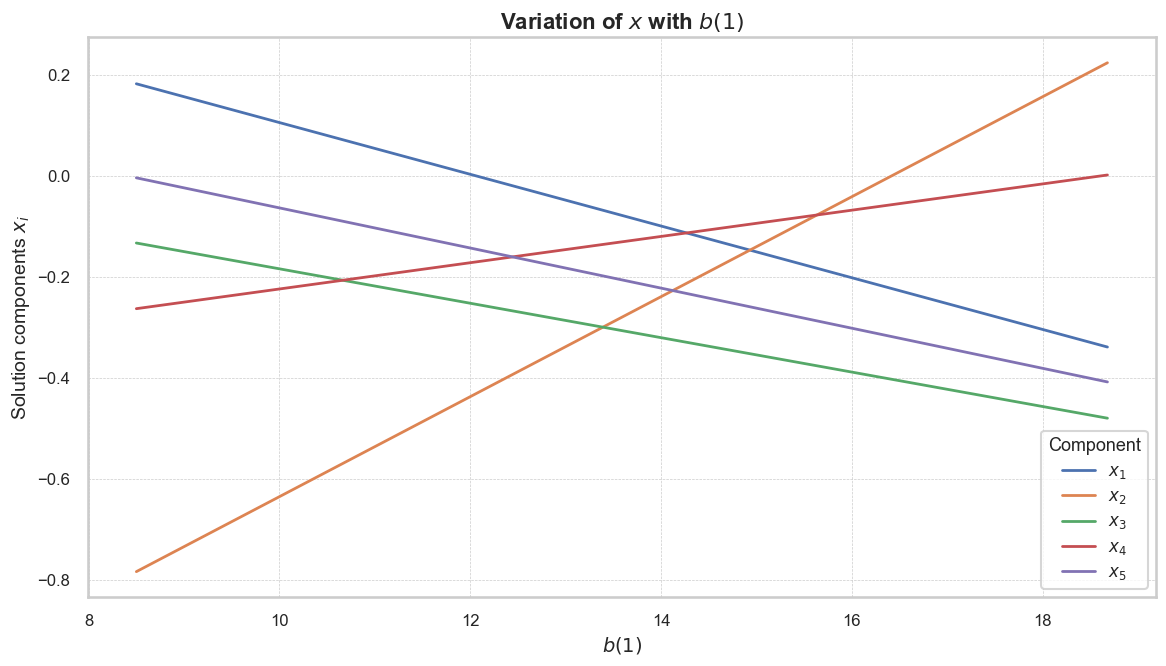

In [11]:
H = np.array([
    [6.0000, 1.8600, 1.2400, 1.4800, -0.4600],
    [1.8600, 4.0000, 0.4400, 1.1200, 0.5200],
    [1.2400, 0.4400, 3.8000, 1.5600, -0.5400],
    [1.4800, 1.1200, 1.5600, 7.2000, -1.1200],
    [-0.4600, 0.5200, -0.5400, -1.1200, 7.8000]
])

g = np.array([-16.1000, -8.5000, -15.7000, -10.0200, -18.6800])

# matrix A (2x5) and vector b (2x1)
A = np.array([
    [16.1000, 8.5000, 15.7000, 10.0200, 18.6800],
    [1.0000,  1.0000, 1.0000,  1.0000,  1.0000]
])

# b(1) values
b1_values = np.linspace(8.5, 18.68, 100)

solutions = []

for b1 in b1_values:
    b = np.array([b1, 1.0])
    
    # form KKT system
    KKT = np.block([
        [H, A.T],
        [A, np.zeros((2, 2))]
    ])
    rhs = -np.concatenate([g, b])
    
    sol = la.solve(KKT, rhs)
    x = sol[:5]
    solutions.append(x)

solutions = np.array(solutions)

# plot each component of x as a function of b(1)
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(12, 7), dpi=100)

for i in range(5):
    plt.plot(b1_values, solutions[:, i],
             label=f'$x_{{{i+1}}}$',  # LaTeX-style labels for x_1, x_2, ...
             linewidth=2,
             markersize=4)

plt.xlabel('$b(1)$', fontsize=14)
plt.ylabel('Solution components $x_i$', fontsize=14)
plt.title('Variation of $x$ with $b(1)$', fontsize=16, weight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title='Component', fontsize=12, title_fontsize=13, loc='best')

plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()